In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [13]:
!ls -a humans/woman

.     ..    1.jpg 2.jpg 3.jpg 4.jpg 5.jpg


In [14]:
import os
import shutil

# Path to your dataset root
# root_path = "/content/humans"
root_path = "./humans"

# Remove .ipynb_checkpoints if it ex∂ists inside any folder
for root, dirs, files in os.walk(root_path):
    for d in dirs:
        if d == ".ipynb_checkpoints":
            folder_to_delete = os.path.join(root, d)
            print("Deleting:", folder_to_delete)
            shutil.rmtree(folder_to_delete)


In [15]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Path to your custom image dataset
# All images should be in a folder structure suitable for torchvision.datasets.ImageFolder
# image_folder = "/content/humans"
image_folder = "./humans"

RESIZE=28
NUM_PIXELS=RESIZE*RESIZE

# Define image preprocessing steps:
# 1. Convert to grayscale if needed (optional).
# 2. Resize images to 28x28 (same size as MNIST so the VAE architecture remains unchanged).
# 3. Convert the image to a PyTorch tensor with pixel values in [0, 1].
transform = transforms.Compose([
    transforms.Grayscale(),         # Optional: convert RGB to grayscale for simplicity
    # transforms.Resize((28, 28)),    # Resize all images to 28x28 pixels = 784 pixels 
    transforms.Resize((RESIZE, RESIZE)),    # Resize all images to 256x256 =  65536 pixels
    transforms.ToTensor()           # Convert image to tensor (C x H x W format)
])

# Load images from the folder using ImageFolder.
# Note: ImageFolder expects a structure like: /root/class_name/image.jpg
# If you don’t have subfolders (class names), either wrap DatasetFolder or write a custom dataset.
custom_dataset = datasets.ImageFolder(
    root=image_folder,
    transform=transform
)

# Load data in batches. Shuffle to randomize input order during training.
custom_loader = DataLoader(custom_dataset, batch_size=5, shuffle=True)

# ✅ Test if it works
for images, labels in custom_loader:
    print("Image batch shape:", images.shape)
    break

Image batch shape: torch.Size([5, 1, 28, 28])


In [16]:
# Use GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
# Define the Variational Autoencoder model
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=256, latent_dim=2):
        """
        input_dim: total pixels in image (28x28 = 784)
        hidden_dim: size of intermediate hidden layer
        latent_dim: size of compressed representation (2D for visualization)
        """
        super(VAE, self).__init__()

        # ---- ENCODER ----
        # Map input image to hidden features
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # Learn the mean of the latent space distribution
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        # Learn the log variance of the latent space distribution
        self.fc22 = nn.Linear(hidden_dim, latent_dim)

        # ---- DECODER ----
        # Map latent space back to hidden layer
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        # Map to original image size with pixel values between 0 and 1
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        """Encodes input into a mean and log-variance vector"""
        h = F.relu(self.fc1(x))             # Hidden layer with ReLU
        return self.fc21(h), self.fc22(h)   # Return mean and log variance

    def reparameterize(self, mu, logvar):
        """
        Sample from N(mu, var) using the reparameterization trick:
        z = mu + std * epsilon, where epsilon ~ N(0, 1)
        """
        std = torch.exp(0.5 * logvar)       # Convert log variance to standard deviation
        eps = torch.randn_like(std)         # Random normal noise
        return mu + eps * std               # Sample from the learned distribution

    def decode(self, z):
        """Decodes latent vector back to image"""
        h = F.relu(self.fc3(z))             # Hidden layer
        return torch.sigmoid(self.fc4(h))   # Output pixel values in range (0,1)

    def forward(self, x):
        """Defines the full VAE pipeline"""
        mu, logvar = self.encode(x.view(-1, 784))      # Flatten image and encode
        z = self.reparameterize(mu, logvar)            # Sample from latent space
        return self.decode(z), mu, logvar              # Reconstruct image


In [18]:
# VAE loss: combination of reconstruction loss and KL divergence
def vae_loss(recon_x, x, mu, logvar):
    """
    recon_x: reconstructed image
    x: original image
    mu, logvar: mean and log variance of latent distribution
    """
    # How close is the reconstruction to the original?
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    # How far is the learned distribution from a normal Gaussian?
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD  # Total loss

In [19]:
model = VAE(input_dim=NUM_PIXELS).to(device)  # Move model to GPU if available
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Optimizer for training

# Training loop
model.train()  # Set model to training mode
for epoch in range(1000):  # Number of epochs (adjust based on dataset size)
    train_loss = 0  # Reset loss counter each epoch
    for batch_idx, (data, _) in enumerate(custom_loader):  # Get a batch of images
        data = data.to(device)              # Move data to GPU/CPU
        optimizer.zero_grad()               # Clear gradients from the previous step
        recon_batch, mu, logvar = model(data)  # Forward pass: encode -> sample -> decode
        loss = vae_loss(recon_batch, data, mu, logvar)  # Compute VAE loss
        loss.backward()                     # Backpropagation: compute gradients
        train_loss += loss.item()           # Accumulate loss for reporting
        optimizer.step()                    # Update model weights

    # Print average loss per image after each epoch
    print(f"Epoch {epoch+1}, Loss: {train_loss / len(custom_loader.dataset):.4f}")


Epoch 1, Loss: 549.0481
Epoch 2, Loss: 542.6770
Epoch 3, Loss: 535.7200
Epoch 4, Loss: 532.7596
Epoch 5, Loss: 526.2967
Epoch 6, Loss: 517.7650
Epoch 7, Loss: 524.5691
Epoch 8, Loss: 508.8463
Epoch 9, Loss: 509.9930
Epoch 10, Loss: 506.2931
Epoch 11, Loss: 502.1218
Epoch 12, Loss: 493.9186
Epoch 13, Loss: 495.3122
Epoch 14, Loss: 488.3848
Epoch 15, Loss: 486.6944
Epoch 16, Loss: 491.3462
Epoch 17, Loss: 486.8259
Epoch 18, Loss: 484.3879
Epoch 19, Loss: 482.9141
Epoch 20, Loss: 482.4979
Epoch 21, Loss: 481.8701
Epoch 22, Loss: 479.8831
Epoch 23, Loss: 477.4722
Epoch 24, Loss: 476.5406
Epoch 25, Loss: 477.8540
Epoch 26, Loss: 476.4078
Epoch 27, Loss: 472.1895
Epoch 28, Loss: 472.5327
Epoch 29, Loss: 468.6965
Epoch 30, Loss: 467.3418
Epoch 31, Loss: 465.3062
Epoch 32, Loss: 463.9378
Epoch 33, Loss: 463.6073
Epoch 34, Loss: 462.4139
Epoch 35, Loss: 459.4499
Epoch 36, Loss: 455.5973
Epoch 37, Loss: 454.1502
Epoch 38, Loss: 452.1848
Epoch 39, Loss: 451.0165
Epoch 40, Loss: 448.5860
Epoch 41,

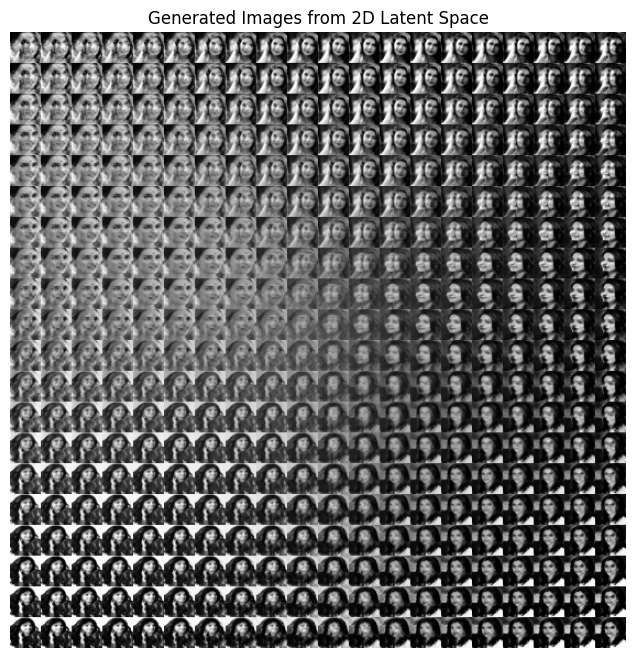

In [20]:
model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient calculation for inference
    n = 20  # Grid size (20x20 = 400 images)
    digit_size = 28  # Output image size
    figure = torch.zeros(digit_size * n, digit_size * n)  # Create a blank canvas

    # Create evenly spaced coordinates in latent space (from -3 to +3)
    grid_x = torch.linspace(-3, 3, n)
    grid_y = torch.linspace(-3, 3, n)

    # For each coordinate in the grid
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z = torch.tensor([[xi, yi]]).to(device)  # Create latent vector z
            sample = model.decode(z).cpu().view(28, 28)  # Decode to image and reshape
            # Place image in the correct spot on the canvas
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = sample

# Show the canvas of generated images
plt.figure(figsize=(8, 8))
plt.imshow(figure, cmap='gray')  # Show as grayscale image
plt.axis('off')
plt.title("Generated Images from 2D Latent Space")
plt.show()


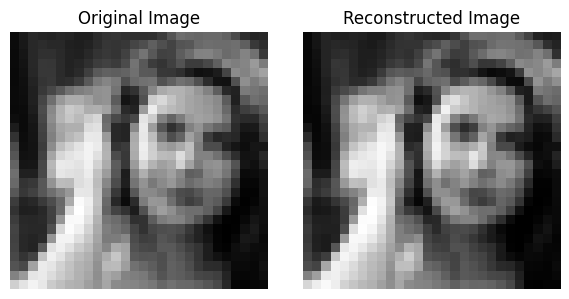

In [21]:
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()

# Get one batch of images
data_iter = iter(custom_loader)
images, _ = next(data_iter)

# Select a single image from the batch and move it to device
original_img = images[0].unsqueeze(0).to(device)  # Shape: [1, 1, 28, 28]

# Reconstruct the image using the VAE
with torch.no_grad():
    reconstructed_img, _, _ = model(original_img)

# Remove batch and channel dimensions and reshape from [784] to [28, 28]
original_np = original_img.squeeze().cpu().numpy()          # [28, 28]
reconstructed_np = reconstructed_img.view(28, 28).cpu().numpy()  # [28, 28]

# Plot the original and reconstructed image
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.imshow(original_np, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_np, cmap='gray')
plt.title("Reconstructed Image")
plt.axis('off')

plt.tight_layout()
plt.show()


In [22]:
import torch
import matplotlib.pyplot as plt

def morph_faces(model, image1, image2, steps=10):
    """
    Interpolates (morphs) between two faces using the VAE's latent space.

    Parameters:
    - model: trained VAE model
    - image1, image2: input face tensors (shape: [1, 1, 28, 28])
    - steps: number of intermediate faces to generate

    Returns:
    - Displays a row of morphed faces between image1 and image2
    """
    model.eval()  # Evaluation mode

    with torch.no_grad():
        # Flatten and encode both images to get their mean latent vectors
        mu1, _ = model.encode(image1.view(-1, 784).to(device))
        mu2, _ = model.encode(image2.view(-1, 784).to(device))

        # Linearly interpolate between the two latent vectors
        interpolated_images = []
        for alpha in torch.linspace(0, 1, steps):
            z = mu1 * (1 - alpha) + mu2 * alpha  # Linear blend
            recon = model.decode(z).view(28, 28).cpu()
            interpolated_images.append(recon)

        # Plot the interpolated images
        plt.figure(figsize=(steps, 2))
        for i, img in enumerate(interpolated_images):
            plt.subplot(1, steps, i + 1)
            plt.imshow(img, cmap='gray')
            plt.axis('off')
        plt.suptitle("Face Morphing via Latent Space")
        plt.tight_layout()
        plt.show()


In [23]:
def generate_random_faces(model, n=10):
    """
    Samples and decodes 'n' random latent vectors to generate new face images.

    Parameters:
    - model: trained VAE model
    - n: number of random faces to generate

    Returns:
    - Displays n newly generated faces from the latent space
    """
    model.eval()

    with torch.no_grad():
        # Sample n points from a standard normal distribution (latent space)
        z = torch.randn(n, 2).to(device)  # 2 = latent_dim
        generated = model.decode(z).view(-1, 28, 28).cpu()

        # Plot the generated images
        plt.figure(figsize=(n, 2))
        for i in range(n):
            plt.subplot(1, n, i + 1)
            plt.imshow(generated[i], cmap='gray')
            plt.axis('off')
        plt.suptitle("Randomly Sampled Faces")
        plt.tight_layout()
        plt.show()


In [24]:
# Get two face images from your dataset
data_iter = iter(custom_loader)
images, _ = next(data_iter)

# Pick any two images
img1 = images[0].unsqueeze(0).to(device)  # Shape: [1, 1, 28, 28]
img2 = images[1].unsqueeze(0).to(device)


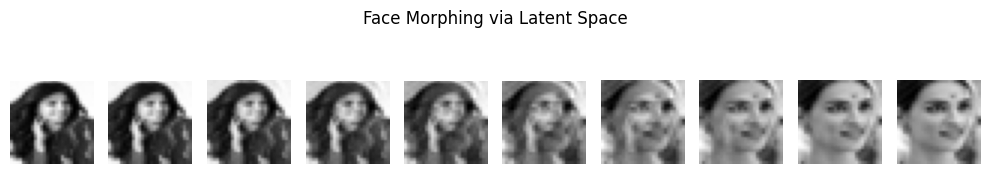

In [25]:
morph_faces(model, img1, img2, steps=10)


In [26]:
def morph_faces(model, image1, image2, steps=10, return_midpoint=True):
    """
    Interpolates (morphs) between two faces using the VAE's latent space.

    Parameters:
    - model: trained VAE model
    - image1, image2: input face tensors (shape: [1, 1, 28, 28])
    - steps: number of intermediate faces to generate
    - return_midpoint: if True, return the middle face; else, return final face

    Returns:
    - Displays interpolation steps
    - Returns the selected final face as a NumPy array
    """
    model.eval()

    with torch.no_grad():
        # Encode both faces into latent space
        mu1, _ = model.encode(image1.view(-1, 784).to(device))
        mu2, _ = model.encode(image2.view(-1, 784).to(device))

        # Interpolate between them
        interpolated_images = []
        for alpha in torch.linspace(0, 1, steps):
            z = mu1 * (1 - alpha) + mu2 * alpha
            recon = model.decode(z).view(28, 28).cpu()
            interpolated_images.append(recon)

        # Plot all interpolated faces
        plt.figure(figsize=(steps, 2))
        for i, img in enumerate(interpolated_images):
            plt.subplot(1, steps, i + 1)
            plt.imshow(img, cmap='gray')
            plt.axis('off')
        plt.suptitle("Face Morphing via Latent Space")
        plt.tight_layout()
        plt.show()

        # Return the final morphed face (last or midpoint)
        final_face = interpolated_images[steps // 2] if return_midpoint else interpolated_images[-1]

        # Display the selected final face
        plt.figure(figsize=(2, 2))
        plt.imshow(final_face, cmap='gray')
        plt.title("Final Morphed Face")
        plt.axis('off')
        plt.show()

        return final_face.numpy()


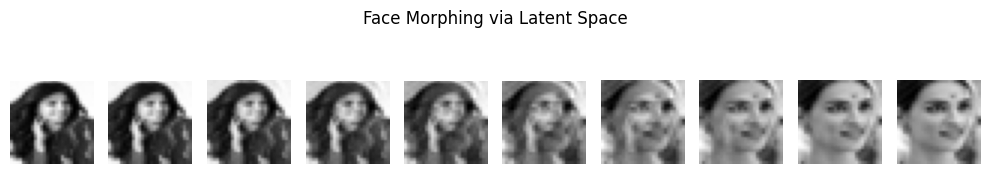

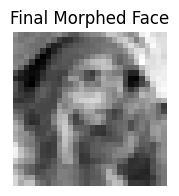

In [27]:
# Pick two images
img1 = images[0].unsqueeze(0).to(device)
img2 = images[1].unsqueeze(0).to(device)

# Call morph function
final_face = morph_faces(model, img1, img2, steps=10, return_midpoint=True)


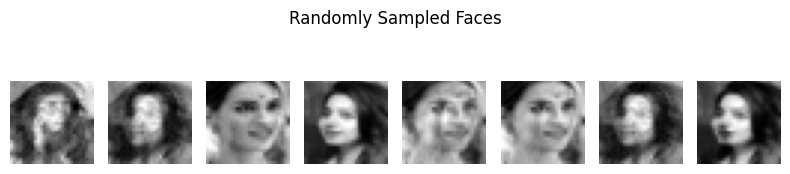

In [28]:
generate_random_faces(model, n=8)
